#Моя первая сверточная нейросеть :0


## Импортирование библиотек, загрузка стоп-слов и датасета (обзоры фильмов с метками positive/negative)

In [1]:
import re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [2]:
with open('stopwords.txt', 'r', encoding='utf-8') as f:
  sw = f.read()

In [3]:
data = pd.read_csv('IMDB Dataset.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Препроцессинг данных
  - **Чистка данных**
  - **Токенизация + векторизация**  с помощью токенизатора TensorFlow/Keras
  - **Паддинг/усечение** (транкейшн) текстовых последовательностей
  - **Разделение датасета** на обучающую, проверочную и тестовую выборки

In [4]:
import re

def cleaning(text, sw=sw):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  text = [word for word in text.split() if word not in sw]

  return ' '.join(text)


data['review'] = data['review'].apply(cleaning)
data['review'].head(10)

,review
0,one reviewers mentioned watching just oz episo...
1,wonderful little production br br filming tech...
2,thought wonderful way spend time hot summer we...
3,basically theres family little boy jake thinks...
4,petter matteis love time money visually stunni...
5,probably alltime favorite movie story selfless...
6,sure like see resurrection dated seahunt serie...
7,show amazing fresh innovative idea first aired...
8,encouraged positive comments film looking forw...
9,like original gut wrenching laughter will like...


In [6]:
# Разделение данных на текст и метки
texts = data['review'].values
labels = data['sentiment'].map({'positive': 1, 'negative': 0}).values

# Создание слоя TextVectorization
max_tokens = 10000  # Максимальное количество слов в словаре
sequence_length = 250  # Максимальная длина последовательности
vectorizer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=sequence_length)

# Адаптация слоя к данным
vectorizer.adapt(texts)

# Преобразование текста в числовые последовательности
vectorized_texts = vectorizer(texts).numpy()

print(f"Пример векторизованного текста:\n\n {vectorized_texts[33]} \n\nПример другого текста: \n\n {vectorized_texts[3]}")

# Слой TextVectorization автоматически выполняет паддинг и усечение до указанной длины (output_sequence_length). Если длина текста меньше, он дополняется нулями; если больше — обрезается.

Пример векторизованного текста:

 [   5 2536 4427  305    4 9466 2166 1863 3956    1    1    1 2916    1
 4703 1640    1 2394 2847 1485  253    4  445    1 4221    1 1393    1
    1 9436  131  592   61    1  828 3536 1485 7332  137  532 8992   49
  188  168 6866 8519 1949 1620 1401    1 2027  254 2033  864  522    1
  258 7311    1    1 1276 4993    1 5192    1 1949 2789 1459  428 2380
 1762  568    1    1    1  106  100  966  860 2908  518  401   77    1
 2166  254  721  694  123    1 2166  426  721 2670 3010   44  964   37
  475  175  382  329    1    1 4867    2    2 2492 6718   35    1    1
    1 7082  339    9    1  134    1    1   48 4969 5308  338    5  121
  178    1 2008 1531    5  121    1    1  913  128 4764 2908  518   22
  236    4   99 1850  483  719 2248    1  360 2611 1393 2894    1 6136
  894 3112 1282 4654 4392 1163   90   50   99  330 1646 2248    7 3045
 6489 3981 3846    4 3986  391 1952    1    1 1409 1891   44 6718   35
 5009 1672  415  117   98   19 6422    1 18

In [7]:
from sklearn.model_selection import train_test_split

# Разделение на обучающую, проверочную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(vectorized_texts, labels, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Выборки:\n")
print("Обучающая:", X_train.shape, y_train.shape)
print("Проверочная:", X_val.shape, y_val.shape)
print("Тестовая:", X_test.shape, y_test.shape)

Выборки:

Обучающая: (35000, 250) (35000,)
Проверочная: (7500, 250) (7500,)
Тестовая: (7500, 250) (7500,)


## Построение и компиляция модели

In [8]:
# Параметры
embedding_dim = 128
num_filters = 64
kernel_size = 6  # Размер ядра свертки. Он записан не в виде матрицы, потому что для обработки текстовых данных используется одномерная свертка.
dropout_rate = 0.5

# Построение модели
model = Sequential([
    Embedding(input_dim=max_tokens, output_dim=embedding_dim),
    # Та самая одномерная свертка Conv1D
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Компиляция
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Я пыталась поставить параметр learning_rate через optimizer=Adam(learning_rate), но модель давала сбой и чат-гпт дал такое решение.

## Наконец-то! Обучение!

In [9]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=30)

Epoch 1/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 87s 71ms/step - accuracy: 0.7388 - loss: 0.4972 - val_accuracy: 0.8768 - val_loss: 0.2851
Epoch 2/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 84s 72ms/step - accuracy: 0.9342 - loss: 0.1844 - val_accuracy: 0.8772 - val_loss: 0.3054
Epoch 3/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 86s 73ms/step - accuracy: 0.9855 - loss: 0.0540 - val_accuracy: 0.8707 - val_loss: 0.3981
Epoch 4/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - accuracy: 0.9958 - loss: 0.0164 - val_accuracy: 0.8739 - val_loss: 0.5321
Epoch 5/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 87s 74ms/step - accuracy: 0.9973 - loss: 0.0096 - val_accuracy: 0.8751 - val_loss: 0.5695


## Оценка и визуализация

In [10]:
# Оценка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8800 - loss: 0.5404
Точность на тестовой выборке: 0.8752


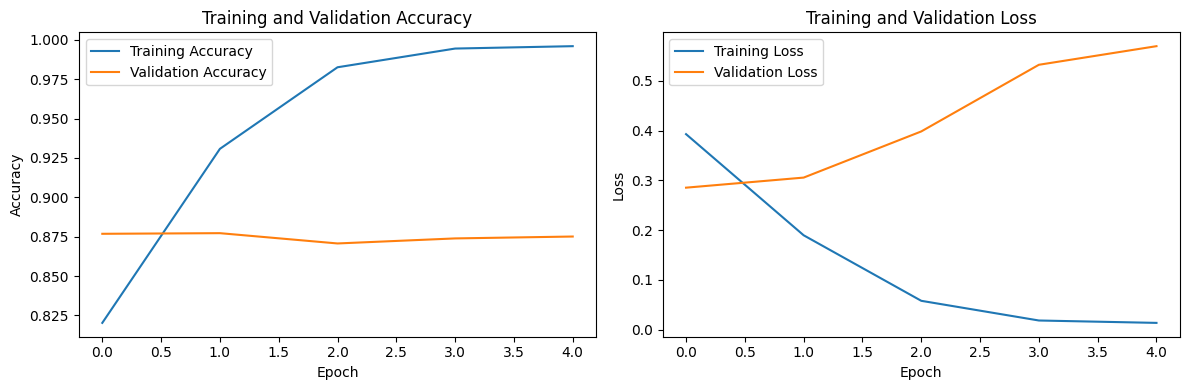

In [11]:
# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


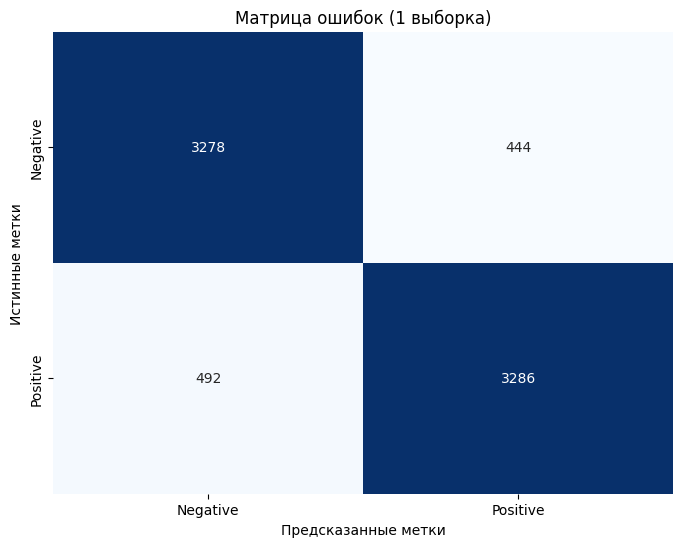

In [12]:
# Получение предсказаний
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (1 выборка)')
plt.show()

## Поменяем некоторые параметры и посмотрим, станет ли лучше.
Я меняла размерность ядра свертки, количество эпох и размерность батча в качестве эксперимента

In [18]:
embedding_dim = 128
num_filters = 64
kernel_size = 4  # Уменьшила размер ядра с 6 до 4
dropout_rate = 0.5

model = Sequential([
    Embedding(input_dim=max_tokens, output_dim=embedding_dim),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2, # Уменьшила количество эпох на 3
    batch_size=50 # Увеличила батч с 30 до 50
)

Epoch 1/2
700/700 ━━━━━━━━━━━━━━━━━━━━ 64s 87ms/step - accuracy: 0.7308 - loss: 0.5125 - val_accuracy: 0.8365 - val_loss: 0.3570
Epoch 2/2
700/700 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.9304 - loss: 0.1969 - val_accuracy: 0.8791 - val_loss: 0.3041


In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8821 - loss: 0.2911
Точность на тестовой выборке: 0.8773


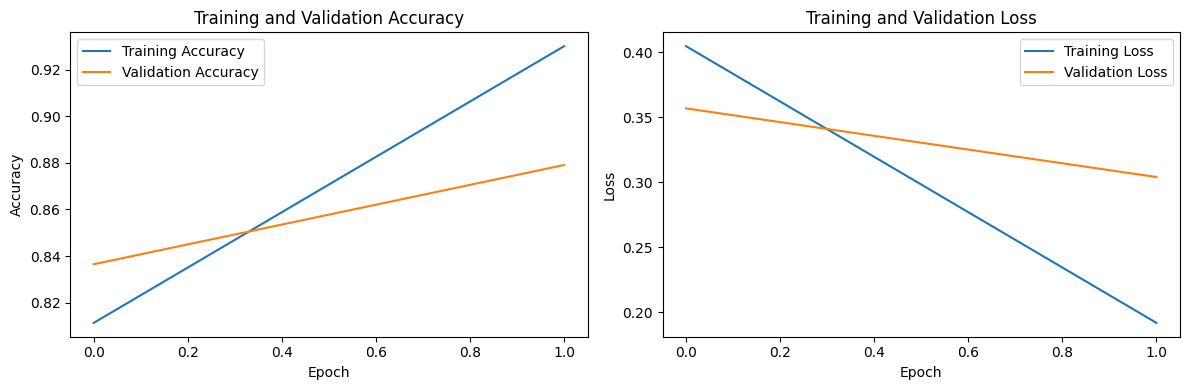

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


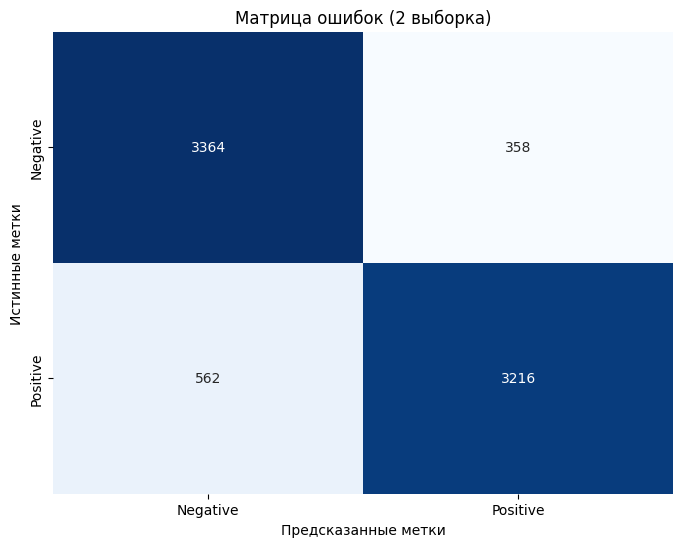

In [20]:
# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (2 выборка)')
plt.show()

## Мне кажется, что стало немного лучше...

In [17]:
model.save('my_first_CNN.keras')